Наша цель – востановить зависимость $ f: X \rightarrow Y $.
Востанавливать её будем по набдюдениям, приближая набором деревьев решений.

In [1]:
import sys
import numpy as np
import xgboost as xgb
# !{sys.executable} -m pip  install sklearn-evaluation
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pwd

/Users/polina/Documents/SeaWaves


# Считываем $X$ #

## Готовим имена признаков ##

1) sk_le [dB/Hz] наклон слева, коэффициент при аппроксимации полином первой степени методом наименьших квадратов участка линии на Рис.1 в диапазоне [-1.75; -0.75] Гц, должен быть положительным.
2) sk_ri [dB/Hz] наклон справа, -"- в диапазоне [0.75; 1.75] Гц, -"- отрицательным
3) centr1 [Hz] средневзвешенное значение частоты
4) centr2 [Hz] среднемедианное значение частоты
5) lvl [dB] уровень сигнала
6) sk_le2[dB/Hz] - второй наклон слева в диапазоне [-3.2; -1.45] Гц
7) sk_ri2[dB/Hz] - второй наклон справа в диапазоне [1.45; 3.2;] Гц
8) lv_brag_le [dB] - уровень сигнала слева в диапазоне 1Гц вокруг частоты Брегга -2±0.5Гц 
9) lv_brag_ri[dB]- уровень сигнала справа в диапазоне +2±0.5Гц

In [4]:
times = [0.3355, 0.671, 1.07, 1.342, 1.678, 2.01, 2.35, 2.68]
# angles = list(range(-90, 100, 10))
angles = list(range(-90, 100, 30))
features = ['sk_le', 'sk_ri', 'centr1', 'centr2', 'lvl', 'sk_le2', 'sk_ri2', 'lv_brag_le', 'lv_brag_ri'] 
all_features = [] 
for feature in features:
    for angle in angles:
        for time in times:
            all_features.append(f'{feature} {angle} {time}')

## Пробегаемся по всем дням и всем файлам внутри дня и формируем список словарей list_dict ##

In [5]:
!ls /Users/polina/Downloads/2720Hz/features_dat/31

01_00_half1.dat 04_00_half1.dat 10_00_half2.dat 19_00_half1.dat 22_00_half1.dat
01_00_half2.dat 04_00_half2.dat 12_00_half2.dat 19_00_half2.dat 22_00_half2.dat
02_00_half1.dat 05_00_half1.dat 14_30_half1.dat 20_05_half1.dat 23_00_half1.dat
02_00_half2.dat 05_00_half2.dat 14_30_half2.dat 20_05_half2.dat 23_00_half2.dat
03_00_half1.dat 06_00_half1.dat 17_00_half1.dat 21_05_half1.dat 23_59_half1.dat
03_00_half2.dat 06_00_half2.dat 17_00_half2.dat 21_05_half2.dat 23_59_half2.dat


In [6]:
from datetime import datetime, timezone, timedelta

In [7]:
days = !ls /Users/polina/Downloads/2720Hz/features_dat
# days = !ls /home/acoustic/ddrazumov/2720Hz/features_dat
days

['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

In [8]:
days

['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']

In [9]:
import pandas as pd
start_date = datetime(2021, 9 , 1)
def read_XY(freq):
    list_dict = []
    for day in days:
        folder_date = start_date + timedelta(days = int(day) -1 )
        folder = f'/Users/polina/Downloads/{freq}/features_dat/{day}'
        # folder = f'/home/acoustic/ddrazumov/2720Hz/features_dat/{day}'
        files = !ls {folder}
        for file in files:
            if file[-3:] != 'dat':
                continue 
            # print('day', day,'file:', file)
            data = !cat {folder}/{file}
            # data = !cat {file}
            data = [ float(t) for line in data for t in line.split() ] 
            end_hour = int(file.split('_')[0])
            end_minutes = int(file.split('_')[1])
            end_minutes = round(end_minutes /30)*30
            half = (3 - int(file.split('_')[2][4]))*30
            start_time = folder_date + timedelta(hours =  end_hour, minutes = end_minutes ) 
            start_time = start_time - timedelta(minutes = half)
            end_time = start_time + timedelta(minutes = 30) 
            dd = {feature:t for feature, t in zip(all_features, data)}

            dd['start_time'] = start_time
            dd['end_time'] = end_time
            list_dict.append(dd)
    sound_df = pd.DataFrame(list_dict)
    sound_df.set_index('start_time', inplace=True)
    sound_df.index = sound_df.index.tz_localize('Etc/GMT+3')

    # Колонки: <br>
    # 1 — номер <br>
    # 2 — дата и время <br>
    # 3-6 – adcp верхний слой две по координатам и две по модуль направление (порядок этих пар может быть перепутан) <br>
    # 5-10 — adcp — нижний слой <br>
    # 11-14 — ветер 

    y_file = '/Users/polina/Downloads/20_09_2021_part0.dat'
    columns = ['time', 'adcp_up1', 'adcp_up2', 'adcp_down1', 'adcp_down2', 'adcp_down3', 'adcp_down4', 'adcp_down5', 'adcp_down6', 'wind1', 'wind2', 'wind3', 'wind4' ]
    Y_df = pd.read_csv(y_file, sep='\s+', header=None, names = columns, index_col = 0)
    Y_df.time = pd.to_datetime(Y_df.time, format='%d.%m.%y_%H:%M:%S')

    buoy_file = '/Users/polina/Downloads/Буй Кацивели21.xlsx'
    buoy_file_df = pd.read_excel(buoy_file, sheet_name='Лист1',  engine='openpyxl',)
    buoy_file_df.rename(columns={'Date/Time': 'start_time'}, inplace=True)
    buoy_file_df['start_time'] = buoy_file_df['start_time'].dt.tz_localize('Etc/GMT+3')
    buoy_file_df.set_index('start_time', inplace=True)
    buoy_file_df.index = buoy_file_df.index.tz_convert('UTC')

    df = pd.merge(left = sound_df, right = buoy_file_df, left_index=True, right_index=True )

    X = df[all_features]

    df['waves_power'] = 1/ (df['Tz'] * df['Tz'])
    df['Y_x'] = np.cos(np.deg2rad( df['Dirp']) ) * df['waves_power']
    df['Y_y'] = np.sin(np.deg2rad( df['Dirp']) ) * df['waves_power']

    Y = df[['Y_x', 'Y_y', 'Dirp', 'waves_power', 'Hm0', 'TI', 'T1', 'Tc', 'Tdw2', 'Tdw1', 'Tpc', 'nu', 'eps', 'QP', 'Ss', 'TRef', 'TSea', 'Bat', 'N', 'E'] ] 
    return X,Y

In [10]:
Xs = {}
Xs['1320Hz'], Y = read_XY('1320Hz')
Xs['2020Hz'], Y = read_XY('2020Hz')
Xs['2080Hz'], Y = read_XY('2080Hz')
Xs['2720Hz'], Y = read_XY('2720Hz')
# Y['Y_x'] = Y['Y_x'] / Y['Y_x'].std()
# Y['Y_y'] = Y['Y_y'] / Y['Y_y'].std()

In [56]:
Xs['1320Hz']

,sk_le -90 0.3355,sk_le -90 0.671,sk_le -90 1.07,sk_le -90 1.342,sk_le -90 1.678,sk_le -90 2.01,sk_le -90 2.35,sk_le -90 2.68,sk_le -60 0.3355,sk_le -60 0.671,...,lv_brag_ri 60 2.35,lv_brag_ri 60 2.68,lv_brag_ri 90 0.3355,lv_brag_ri 90 0.671,lv_brag_ri 90 1.07,lv_brag_ri 90 1.342,lv_brag_ri 90 1.678,lv_brag_ri 90 2.01,lv_brag_ri 90 2.35,lv_brag_ri 90 2.68
start_time,,,,,,,,,,,,,,,,,,,,,
2021-09-20 12:30:00+00:00,7.731651,2.441708,0.027424,-3.408708,1.267204,-3.721537,-8.650002,-4.745698,7.714575,3.099664,...,-58.794305,-61.183074,-48.540879,-54.570472,-54.932336,-55.579674,-56.498984,-56.786399,-59.113056,-61.899430
2021-09-20 13:00:00+00:00,9.724335,9.316397,10.360357,5.250668,-0.823545,-1.269012,0.547492,0.577509,9.224927,8.984914,...,-61.960416,-61.246199,-50.146100,-56.900859,-60.572632,-60.590199,-61.347126,-61.784600,-62.965113,-62.087317
2021-09-20 13:30:00+00:00,11.848206,7.031181,5.934137,4.678516,2.131807,0.314250,-0.673302,-0.402059,10.978598,5.922842,...,-57.641193,-58.971489,-47.967610,-54.745984,-56.067107,-58.102752,-59.376422,-57.770049,-58.280509,-59.500370
2021-09-20 15:00:00+00:00,2.296195,-1.592450,1.568652,1.161574,1.771208,1.611643,-3.629144,-3.312730,2.457131,-0.156968,...,-59.078662,-59.782766,-54.895944,-57.589936,-61.702399,-62.245699,-62.540732,-61.600334,-61.061243,-60.906671
2021-09-20 15:30:00+00:00,7.898410,5.946686,6.913246,4.104845,-0.850777,-1.515155,-1.685422,0.687030,7.647329,5.828177,...,-59.118990,-58.220856,-49.943581,-54.823990,-58.007899,-59.255511,-60.237584,-60.506042,-59.892668,-58.729571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02 00:30:00+00:00,9.177321,9.918034,5.634717,4.171949,1.446888,0.667684,-2.181987,1.735686,8.398847,7.709825,...,-52.124126,-50.778062,-43.050339,-48.560995,-49.796030,-50.491998,-51.947003,-54.660844,-52.807840,-51.214340
2021-10-02 01:00:00+00:00,5.184233,6.755721,5.241697,5.512477,4.981966,6.720671,5.389430,3.046101,4.660093,6.928037,...,-51.443359,-51.863655,-42.431982,-50.015946,-52.984122,-53.853783,-54.857918,-54.461479,-52.087174,-52.765944
2021-10-02 01:30:00+00:00,10.483612,8.856688,9.478349,9.797127,6.966956,3.996187,2.987490,0.706217,10.221485,8.559717,...,-48.919074,-49.926339,-43.275150,-49.394659,-52.035808,-50.708320,-50.697960,-50.648787,-49.990111,-51.256458


In [9]:
# import xgboost as xgb
# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 20)
# model = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', n_estimators = 20)
# "booster":"gblinear", "objective":"reg:linear"

In [24]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(model, X, Y, cv=5)


In [25]:
# model.fit(X ,Y, verbose=True )
# model.get_booster().get_score(importance_type='gain')

In [26]:
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib.transforms import Bbox
# matplotlib.transforms.Bbox
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 20)
# model = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror', n_estimators = 20)
model.fit(Xs['2720Hz'],Y['Y_x'], verbose=True )
# ax = plot_importance(model, max_num_features=20, title='Feature perfomance')
# ax.figure.savefig('feature_perfomace_2720Hz.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Оценим как хорошо работает модель #


In [54]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = 100*np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

Y_x| 1320Hz Hz, 5 folds. RMSE mean: 0.03034100385109953, std: 0.006397895250807975, mean%:  104.7557962115607, std%:  22.089467255786406
Y_x| 1320Hz Hz, 5 folds. RMSPE mean: 288.3336518989442%
Y_x| 2020Hz Hz, 5 folds. RMSE mean: 0.029722636255428342, std: 0.0064789874352633265, mean%:  102.62081115457764, std%:  22.369447324700552
Y_x| 2020Hz Hz, 5 folds. RMSPE mean: 332.575567739705%
Y_x| 2080Hz Hz, 5 folds. RMSE mean: 0.029990366142306008, std: 0.007306792931138446, mean%:  103.54517930031005, std%:  25.227540756752944
Y_x| 2080Hz Hz, 5 folds. RMSPE mean: 233.35363139996224%
Y_x| 2720Hz Hz, 5 folds. RMSE mean: 0.03157846806899719, std: 0.00861888153633714, mean%:  109.02828337333561, std%:  29.757677175845892
Y_x| 2720Hz Hz, 5 folds. RMSPE mean: 118.0527390306229%
Y_y| 1320Hz Hz, 5 folds. RMSE mean: 0.059451684516773504, std: 0.019053616246797193, mean%:  109.11917173142731, std%:  34.97150400763467
Y_y| 1320Hz Hz, 5 folds. RMSPE mean: 78.01659993606617%
Y_y| 2020Hz Hz, 5 folds. RMSE

Text(0.5, 0, 'Days')

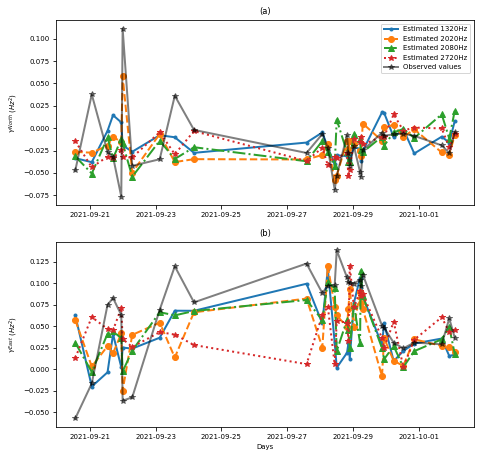

In [55]:
from matplotlib.pyplot import figure
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

plt.rcParams.update({'font.size': 7})
cm = 1/2.54  # centimeters in inches
# [fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
[fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
style_list=['-','--','-.',':'] # list of basic linestyles
marker_list=['.','o', '^', '*']

def mike_style_plot(model, ax_, Xs,Y, target='Y_x' , title="", folds=5, _func=None): 
    # fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(19*cm, 19*cm)
    if _func is None: _func = lambda x: x
    ax_.set_title(title)
    arr = {}
    for (freq, X), style, marker in zip(Xs.items(),style_list,marker_list  ):
        X_train, X_test, y_train, y_test = train_test_split(X, Y[target], test_size=0.1, random_state=108)
        model.fit(X_train, y_train, verbose=True)
        y_test_pred = model.predict(X_test)
        xx, yy, yy_pred = zip(*(sorted(zip(X_test.index, y_test, y_test_pred) ) ))
        ax_.plot(xx, _func(yy_pred),  linewidth=2, linestyle = style, marker=marker, label = f'Estimated {freq}')
        cv_results = cross_validate(model, X, Y[target], scoring='neg_root_mean_squared_error', cv=folds)
        print(f"{target}| {freq} Hz, {folds} folds. RMSE mean: {-np.mean(cv_results['test_score']) }, std: {np.std(cv_results['test_score'])}, mean%:  {100.*-np.mean(cv_results['test_score']) / Y[target].std()}, std%:  {100.*np.std(cv_results['test_score']) / Y[target].std()}" ) 
        print(f"{target}| {freq} Hz, {folds} folds. RMSPE mean: {rmspe(np.array(yy), np.array(yy_pred) )}%" ) 
    
    # plot true values curve
    ax_.plot(xx, _func(yy),  alpha=0.5, linewidth=2, color='black', label = 'Observed values', marker='*')
    
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, max_depth=3)
    
mike_style_plot(model, ax[0], Xs, Y, 'Y_x', '(a)')

ax[0].set_ylabel('$ Y^{North} \; (Hz^2) $')
ax[0].legend()
mike_style_plot(model, ax[1], Xs, Y, 'Y_y', '(b)')
ax[1].set_ylabel('$ Y^{East} \; (Hz^2) $')
ax[1].set_xlabel('Days')


# fig.savefig('_north_east_freq_preds_mikestyle.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight') 

AttributeError: 'AxesSubplot' object has no attribute 'items'

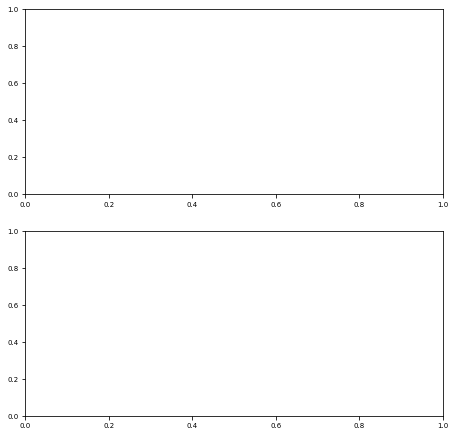

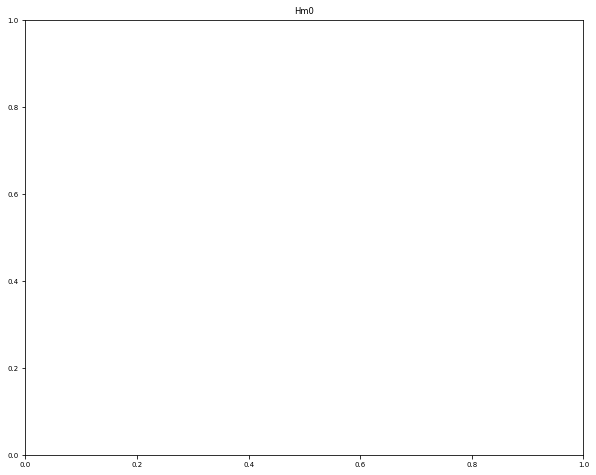

In [113]:
[fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, max_depth=3)
mike_style_plot(model, ax[0], Xs, Y, 'Hm0', '(a)')
ax[0].set_ylabel('$H_{m0}$ (cm)')
ax[0].legend()
mike_style_plot(model, ax[1], Xs, Y, 'waves_power', '(b)', _func=np.sqrt)
ax[1].set_ylabel('$1/T_z$ (Hz)')
ax[1].set_xlabel('Days')

## Wave direction classification

**work with 2720Hz**

In [11]:
dirp_classes = []
for index, row in Y.iterrows():
    if row['Dirp'] <= 90.0:
        dirp_classes.append(0)
    elif row['Dirp'] <= 180.0:
        dirp_classes.append(1)
    elif row['Dirp'] <= 270.0:
        dirp_classes.append(2)
    else:
        dirp_classes.append(3)

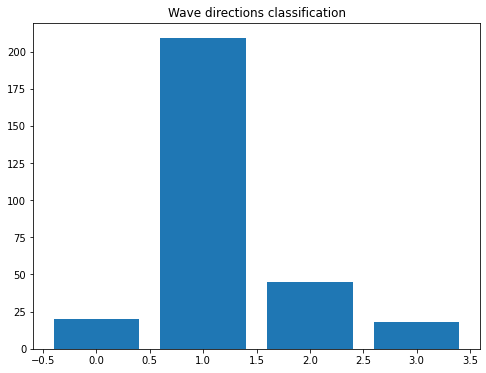

In [12]:
from collections import Counter
dirp_classes_dict = Counter(dirp_classes)

keys = dirp_classes_dict.keys()
values = dirp_classes_dict.values()

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(keys, values)
plt.title('Wave directions classification')
plt.show()

In [13]:
Y['Dirp_class'] = dirp_classes

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
random_forest = RandomForestClassifier(n_estimators=10, max_depth=7, random_state=17)
scores = cross_val_score(random_forest, Xs['2720Hz'], Y['Dirp_class'], scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.726 (0.059)


In [16]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=7, random_state=0)
scores = cross_val_score(gbc, Xs['2720Hz'], Y['Dirp_class'], scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.706 (0.072)


**Parameters optimization**

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
param_grid = {
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [10, 20, 40, 50],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf' : [1, 2, 3],
    'class_weight' : ["balanced"]
}

kfold = KFold(n_splits=10, random_state=1, shuffle=True)
random_forest = RandomForestClassifier()
grid_search = GridSearchCV(random_forest, param_grid, cv=kfold)
grid_search.fit(Xs['2720Hz'], Y['Dirp_class'])

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 20, 40, 50]})

In [40]:
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=40)

In [41]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
random_forest = RandomForestClassifier(max_depth=5,
                                       min_samples_leaf=2,
                                       min_samples_split=3,
                                       n_estimators=40,
                                       class_weight="balanced")
scores = cross_val_score(random_forest, Xs['2720Hz'], Y['Dirp_class'], scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.743 (0.083)


In [21]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

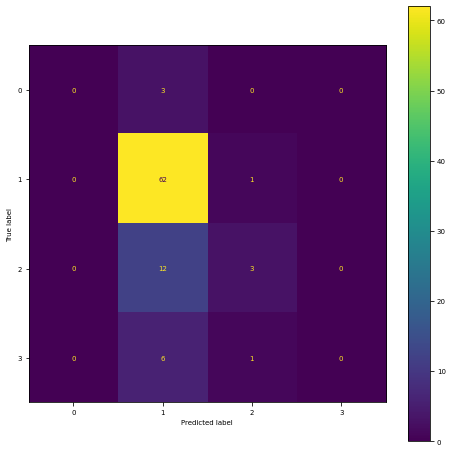

In [42]:
X_train, X_test, y_train, y_test = train_test_split(Xs['2720Hz'], Y['Dirp_class'], test_size=0.3, random_state=108)
model = RandomForestClassifier(max_depth=5,
                               min_samples_leaf=2,
                               min_samples_split=3,
                               n_estimators=40,
                               class_weight="balanced")
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.show()

In [43]:
y_pred = model.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.75      0.98      0.85        63
     class 2       0.60      0.20      0.30        15
     class 3       0.00      0.00      0.00         7

    accuracy                           0.74        88
   macro avg       0.34      0.30      0.29        88
weighted avg       0.64      0.74      0.66        88



**Experiment with class weights**

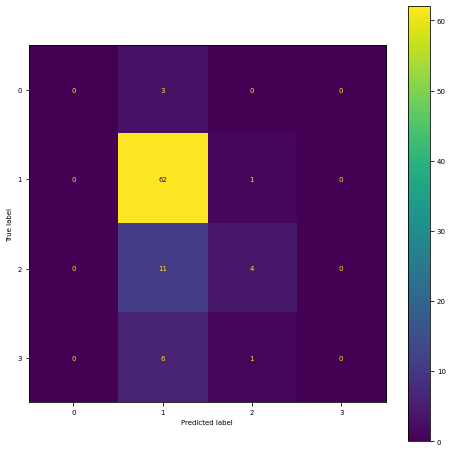

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.76      0.98      0.86        63
     class 2       0.67      0.27      0.38        15
     class 3       0.00      0.00      0.00         7

    accuracy                           0.75        88
   macro avg       0.36      0.31      0.31        88
weighted avg       0.65      0.75      0.68        88



In [86]:
X_train, X_test, y_train, y_test = train_test_split(Xs['2720Hz'], Y['Dirp_class'], test_size=0.3, random_state=108)
model = RandomForestClassifier(max_depth=5,
                               min_samples_leaf=2,
                               min_samples_split=3,
                               n_estimators=40,
                               class_weight={0: 3.0, 1: 0.35, 2: 1.7, 3: 4.63})
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.show()

y_pred = model.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_pred, target_names=target_names))

**Experiment with resampling**

In [48]:
from imblearn.over_sampling import SMOTE

In [50]:
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

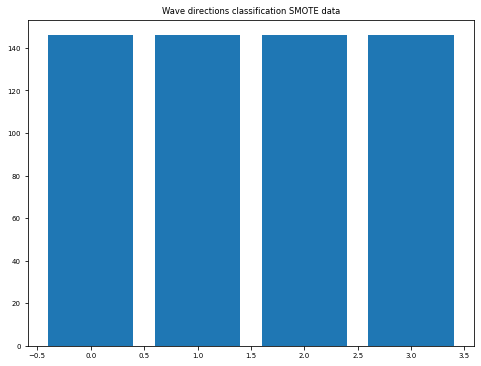

In [58]:
dirp_classes_dict = Counter(y_train_sm)

keys = dirp_classes_dict.keys()
values = dirp_classes_dict.values()

fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(keys, values)
plt.title('Wave directions classification SMOTE data')
plt.show()

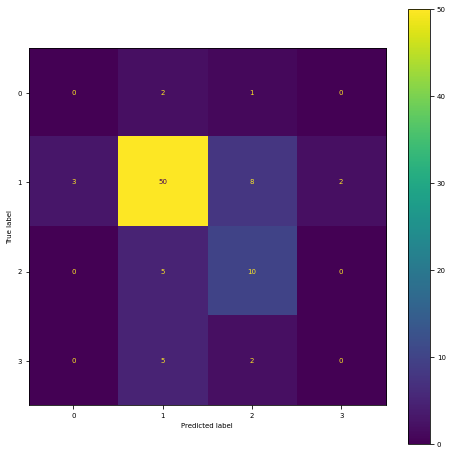

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.81      0.79      0.80        63
     class 2       0.48      0.67      0.56        15
     class 3       0.00      0.00      0.00         7

    accuracy                           0.68        88
   macro avg       0.32      0.37      0.34        88
weighted avg       0.66      0.68      0.67        88



In [85]:
model = RandomForestClassifier(max_depth=9,
                               min_samples_leaf=2,
                               min_samples_split=3,
                               n_estimators=20)
#                                class_weight={0: 3.0, 1: 0.35, 2: 1.7, 3: 4.63})
model.fit(X_train_sm, y_train_sm)

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.show()

y_pred = model.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_pred, target_names=target_names))

**AdaBoostClassifier Experiment**

In [73]:
from sklearn.ensemble import AdaBoostClassifier

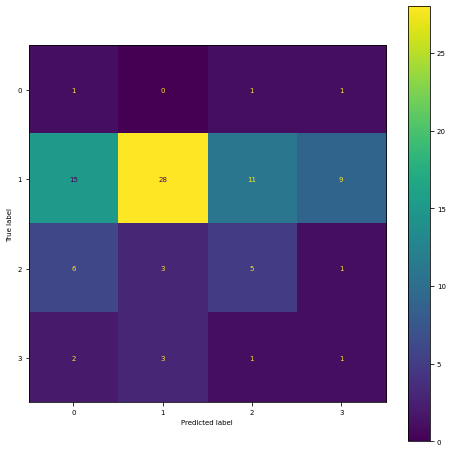

              precision    recall  f1-score   support

     class 0       0.04      0.33      0.07         3
     class 1       0.82      0.44      0.58        63
     class 2       0.28      0.33      0.30        15
     class 3       0.08      0.14      0.11         7

    accuracy                           0.40        88
   macro avg       0.31      0.31      0.26        88
weighted avg       0.64      0.40      0.48        88



In [79]:
model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train_sm, y_train_sm)

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model, X_test, y_test, ax=ax)
plt.show()

y_pred = model.predict(X_test)
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_pred, target_names=target_names))

**Different SMOTE**

In [97]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE

In [107]:
def randomForest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(max_depth=9,
                                   min_samples_leaf=2,
                                   min_samples_split=3,
                                   n_estimators=20)
#                                class_weight={0: 3.0, 1: 0.35, 2: 1.7, 3: 4.63})
    model.fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    plt.show()

    y_pred = model.predict(X_test)
    target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    print(classification_report(y_test, y_pred, target_names=target_names))

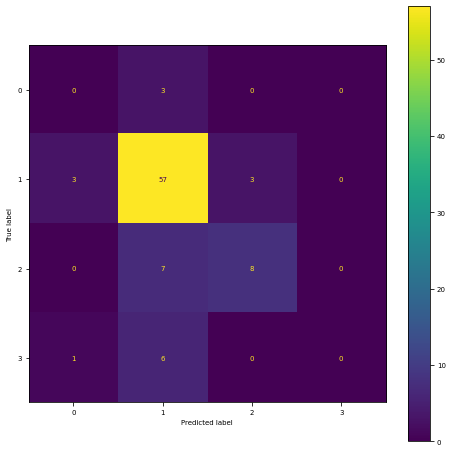

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.78      0.90      0.84        63
     class 2       0.73      0.53      0.62        15
     class 3       0.00      0.00      0.00         7

    accuracy                           0.74        88
   macro avg       0.38      0.36      0.36        88
weighted avg       0.68      0.74      0.70        88



In [108]:
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
randomForest(X_train_sm, y_train_sm, X_test, y_test)

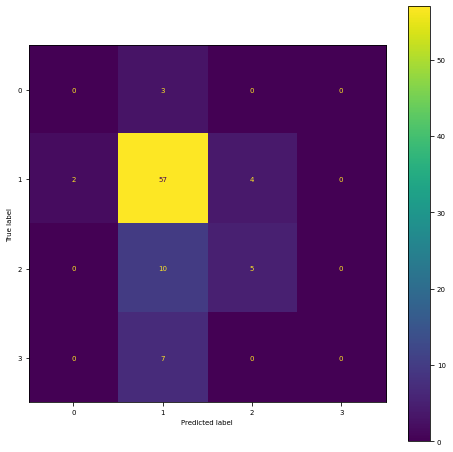

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.74      0.90      0.81        63
     class 2       0.56      0.33      0.42        15
     class 3       0.00      0.00      0.00         7

    accuracy                           0.70        88
   macro avg       0.32      0.31      0.31        88
weighted avg       0.62      0.70      0.65        88



In [109]:
smotenc = SMOTENC([1],random_state = 101)
X_train_sm, y_train_sm = smotenc.fit_resample(X_train, y_train)
randomForest(X_train_sm, y_train_sm, X_test, y_test)

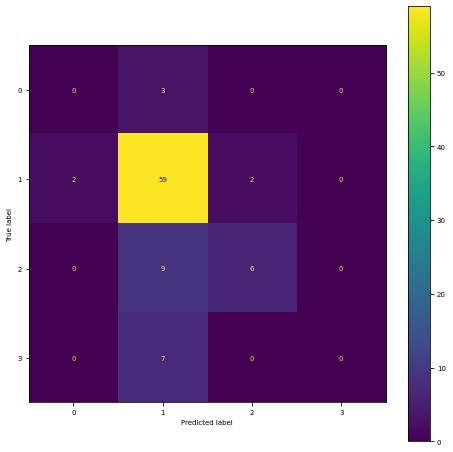

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         3
     class 1       0.76      0.94      0.84        63
     class 2       0.75      0.40      0.52        15
     class 3       0.00      0.00      0.00         7

    accuracy                           0.74        88
   macro avg       0.38      0.33      0.34        88
weighted avg       0.67      0.74      0.69        88



In [110]:
smotenc = BorderlineSMOTE(random_state = 101, kind = 'borderline-1')
X_train_sm, y_train_sm = smotenc.fit_resample(X_train, y_train)
randomForest(X_train_sm, y_train_sm, X_test, y_test)

**compute class weights**

In [32]:
from sklearn.utils.class_weight import compute_class_weight

In [81]:
classes = [0, 1, 2, 3]
cw = compute_class_weight('balanced', classes=classes, y=y_train)

In [82]:
print(cw)

[3.         0.34931507 1.7        4.63636364]


## Wave direction Regression 

In [91]:
from imblearn.over_sampling import SMOTENC

Dirp| 1320Hz Hz, 5 folds. RMSE mean: 81.01558582533713, std: 16.416558671855753, mean%:  124.06089856214248, std%:  25.139027254822444
Dirp| 1320Hz Hz, 5 folds. RMSPE mean: 43.212621411700816%
Dirp| 2020Hz Hz, 5 folds. RMSE mean: 81.81794894088209, std: 11.706452952513184, mean%:  125.28957435425774, std%:  17.926341672024662
Dirp| 2020Hz Hz, 5 folds. RMSPE mean: 45.11606124258137%
Dirp| 2080Hz Hz, 5 folds. RMSE mean: 82.1703408016668, std: 14.21368869480492, mean%:  125.82919954426978, std%:  21.765725365014685
Dirp| 2080Hz Hz, 5 folds. RMSPE mean: 36.86981606578212%
Dirp| 2720Hz Hz, 5 folds. RMSE mean: 78.12596037233652, std: 11.476628609425498, mean%:  119.63595333024392, std%:  17.574406742165824
Dirp| 2720Hz Hz, 5 folds. RMSPE mean: 41.379122286296%


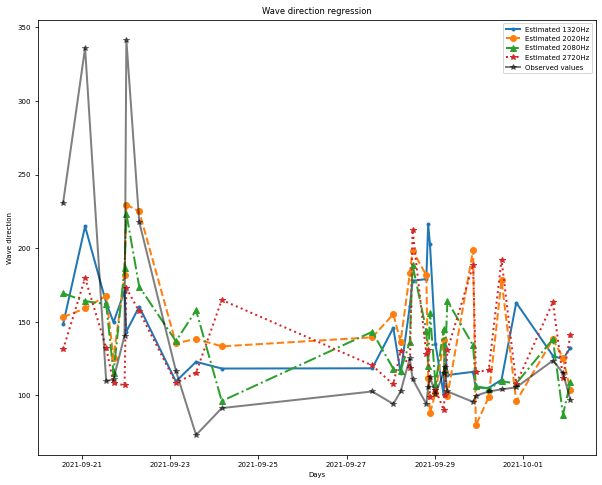

In [93]:
plt.rcParams.update({'font.size': 7})
cm = 1/2.54  # centimeters in inches
# [fig, ax] = plt.subplots(2,1, figsize=(19*cm, 19*cm))
style_list=['-','--','-.',':'] # list of basic linestyles
marker_list=['.','o', '^', '*']

def mike_style_plot(model, Xs, Y, target='Dirp', title="", folds=5, _func=None): 
    # fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(19*cm, 19*cm)
    fig = plt.figure(figsize=(10, 8))
    if _func is None: _func = lambda x: x
    plt.title(title)
    arr = {}
    for (freq, X), style, marker in zip(Xs.items(),style_list,marker_list  ):
        X_train, X_test, y_train, y_test = train_test_split(X, Y[target], test_size=0.1, random_state=108)
#         smotenc = SMOTENC([1],random_state = 101)
#         X_train_sm, y_train_sm = smotenc.fit_resample(X_train, y_train)
        model.fit(X_train, y_train, verbose=True)
        y_test_pred = model.predict(X_test)
        xx, yy, yy_pred = zip(*(sorted(zip(X_test.index, y_test, y_test_pred) ) ))
        plt.plot(xx, _func(yy_pred),  linewidth=2, linestyle = style, marker=marker, label = f'Estimated {freq}')
        cv_results = cross_validate(model, X, Y[target], scoring='neg_root_mean_squared_error', cv=folds)
        print(f"{target}| {freq} Hz, {folds} folds. RMSE mean: {-np.mean(cv_results['test_score']) }, std: {np.std(cv_results['test_score'])}, mean%:  {100.*-np.mean(cv_results['test_score']) / Y[target].std()}, std%:  {100.*np.std(cv_results['test_score']) / Y[target].std()}" ) 
        print(f"{target}| {freq} Hz, {folds} folds. RMSPE mean: {rmspe(np.array(yy), np.array(yy_pred) )}%" ) 
    
    # plot true values curve
    plt.plot(xx, _func(yy),  alpha=0.5, linewidth=2, color='black', label = 'Observed values', marker='*')
    plt.ylabel('Wave direction')
    plt.xlabel('Days')
    plt.legend()

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 30, max_depth=3)
    
mike_style_plot(model, Xs, Y, 'Dirp', 'Wave direction regression')


